In this notebook I'm trying to comprehend the following GMS Tutorial: 
- http://gmstutorials-10.1.aquaveo.com/MT3DMS-HeatTransport.pdf

Which is also available in this YouTube video: 
- https://www.youtube.com/watch?v=-nsY-vKv4FQ

Which is based on this example from MT3DMS (page 152 from orginal PDF): 
- https://hydro.geo.ua.edu/mt3d/mt3dmanual.pdf

That corresponds to example 9 in this Jupyter Notebook: 
- [Example-9.-Two-Dimensional-Application-Example](https://render.githubusercontent.com/view/ipynb?commit=491f4fe3923a942e9a0d535a7da54173c4df1204&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f6d6f64666c6f7770792f666c6f70792f343931663466653339323361393432653961306435333561376461353431373363346466313230342f6578616d706c65732f4e6f7465626f6f6b732f666c6f7079335f4d5433444d535f6578616d706c65732e6970796e62&nwo=modflowpy%2Fflopy&path=examples%2FNotebooks%2Fflopy3_MT3DMS_examples.ipynb&repository_id=28000838&repository_type=Repository#Example-9.-Two-Dimensional-Application-Example)

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
%matplotlib inline

flopy is installed in /Users/mattijnvanhoek/miniconda3/lib/python3.7/site-packages/flopy


In [2]:
workspace = r'/Users/mattijnvanhoek/modflow6/output/mf05-mt3dms-ex9-heat'
if not os.path.exists(workspace):
    os.makedirs(workspace)

In [3]:
# name
modelname = 'mf_heat_transport'

# exe name
exe_mf2005 = r'/Users/mattijnvanhoek/modflow6/bin/mf2005'

mf_model = flopy.modflow.Modflow(
    modelname=modelname, 
    exe_name=exe_mf2005,
    model_ws=workspace
)

In [4]:
Lx = 1600
Ly = 2000
nlay = 1
nrow = 40
ncol = 32
delr = Lx / ncol
delc = Ly / nrow
delv = 10
prsity = 0.3

perlen_mf = 365 * 6 
laytyp = 0
k1 = 1.474e-4
k2 = 1.474e-7

In [5]:
#DIS file
dis = flopy.modflow.ModflowDis(
    model=mf_model, 
    nlay=nlay, 
    nrow=nrow, 
    ncol=ncol,
    delr=delr, 
    delc=delc, 
    top=0., 
    botm=[0 - delv],
    perlen=1,#perlen_mf,
    xul=0,
    yul=0,    
)

In [6]:
# ibound array definition
ibound = np.ones((nlay, nrow, ncol), dtype=np.int)
ibound[0, 0, :] = -1
ibound[0, -1, :] = -1

In [7]:
# start array definition
strt = np.zeros((nlay, nrow, ncol), dtype=np.float)
head_top = 250
head_bottom = 240
strt[0, 0, :] = head_top
strt[0, -1, :] = head_bottom

In [8]:
# hydraulic conductivity array definition
hk = k1 * np.ones((nlay, nrow, ncol), dtype=np.float)
hk[:, 11:17, 5:18] = k2

In [9]:
# well space definition
injection_rate = 5000  # m3/d  divide by 86400 to get m3/s
extraction_rate = -1000 # m3/d divide by 86400 to get m3/s
welspd = [
    [0, 9, 15, injection_rate],  # injection well
    [0, 24, 15, extraction_rate]  # extraction well
]

# well space array definition (for visz purposes only)
ws = np.empty((nlay, nrow, ncol), dtype=np.float)
ws[:] = np.NaN
for w in welspd:
    ws[w[0], w[1], w[2]] = w[3]

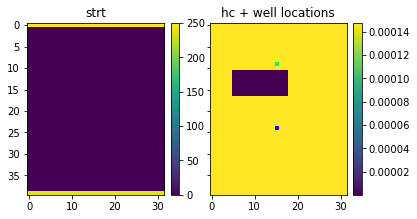

In [10]:
f, ((ax1, ax2)) = plt.subplots(1, 2, sharex=True, sharey=True, )

im1 = ax1.imshow(strt[0])
ax1.set_title('strt')
plt.colorbar(im1, ax=ax1, fraction=0.0565, pad=0.04)

im2 = ax2.imshow(hk[0])
im3 = ax2.imshow(ws[0], cmap='winter')
plt.colorbar(im2, ax=ax2, fraction=0.0565, pad=0.04)
ax2.set_title('hc + well locations')

plt.show() 

In [11]:
# prepare the modflow modules
oc = flopy.modflow.ModflowOc(model=mf_model)
bas = flopy.modflow.ModflowBas(model=mf_model, ibound=ibound, strt=strt)
lpf = flopy.modflow.ModflowLpf(model=mf_model, hk=hk, laytyp=laytyp)
wel = flopy.modflow.ModflowWel(model=mf_model, stress_period_data=welspd)
pcg = flopy.modflow.ModflowPcg(model=mf_model)
lmt = flopy.modflow.ModflowLmt(model=mf_model, output_file_name=f'{workspace}/mt3d_link.ftl')
mf_model.write_input()
mf_model.run_model(silent=False)

FloPy is using the following  executable to run the model: /Users/mattijnvanhoek/modflow6/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: mf_heat_transport.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2020/01/26 22:11:26

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2020/01/26 22:11:26
 Elapsed run time:  0.010 Seconds

  Normal termination of simulation


(True, [])

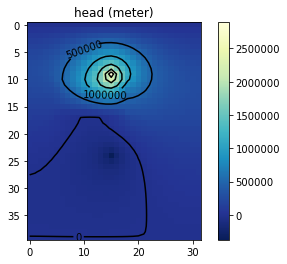

In [12]:
# plot model results
import flopy.utils.binaryfile as bf

# create the headfile object
headfile = f'{modelname}.hds'
fname = os.path.join(workspace, headfile)
headobj = flopy.utils.binaryfile.HeadFile(fname)
head = headobj.get_data(totim=1)
times = headobj.get_times()

# Make the plots
plt.subplot(1, 1, 1, aspect='equal')
plt.title('head (meter)')
plt.imshow(head[0, :, :], cmap='YlGnBu_r')
plt.colorbar()

contours = plt.contour(head[0, :, :], zorder=10, colors='black')
plt.clabel(contours, inline=1, fontsize=10, fmt='%d')

plt.show()

In [13]:
# observe the very high head values..
# if the injection and extraction rate is set to m3/s (instead of m3/d) 
# than this plot will change to more logic values. 
# but than there is insufficient transport in the mt3dms model.

In [14]:
# name
name_mt3d = 'mt-ex9-heat'

# exe name
exe_mt3dms = r'/Users/mattijnvanhoek/modflow6/bin/mt3dms'
# i started using mt3d-usgs, but the results are the same

In [15]:
# create mt3dms model object
mt_model = flopy.mt3d.Mt3dms(
    modelname=name_mt3d, 
    model_ws=workspace, 
    exe_name=exe_mt3dms, 
    modflowmodel=mf_model
)

In [16]:
# basic transport package
sconc = np.zeros((nlay, nrow, ncol), dtype=np.float)
sconc[:] = 278

timprs = np.linspace(25, 2200, 100)
btn = flopy.mt3d.Mt3dBtn(
    model=mt_model, 
    sconc=sconc, 
    prsity=0.3, 
    thkmin=0.01,
    munit='Kelvin', 
    species_names=['warm water'],
    timprs=timprs,
    nprs=len(timprs),
    nprobs=10,
    cinact=-1,
    icbund=ibound,
    perlen=2200,
    ncomp=1,
    nstp=50
)

In [17]:
# advaction package
mixelm = -1  # Third-order TVD scheme (ULTIMATE)
adv = flopy.mt3d.Mt3dAdv(
    model=mt_model, 
    mixelm=mixelm
)

In [18]:
# chemical reaction package
rct = flopy.mt3d.Mt3dRct(
    model=mt_model,
    isothm=1,
    rhob=1961.0,
    sp1=0.00021,
    igetsc=0
)

In [19]:
# dispersion package
al = 0.5  # longitudinal dispersivity
dmcoef = 2.15e-11  # in the yt video they use 1.86e-6, effective molecular diffusion coefficient
trpt = 0.1  # ratio of the horizontal transverse dispersivity to the longitudinal dispersivity
trpv = 0.1  # ratio of the vertical transverse dispersivity to the longitudinal dispersivity

dsp = flopy.mt3d.Mt3dDsp(
    model=mt_model, 
    al=al, 
    dmcoef=dmcoef, 
    trpt=trpt, 
    trpv=trpv
)

In [20]:
# source/sink package
itype = flopy.mt3d.Mt3dSsm.itype_dict()
print(itype)

ssm_data = {}
# heads on 278 Kelvin
for i in range(ncol):
    ssm_data[i] = [(0, 0, i, 278, itype['CHD'])]
for i in range(ncol):
    ssm_data[i+ncol] = [(0, nrow, i, 278, itype['CHD'])]  
# injection well on 298 Kelvin 
ssm_data[ncol+ncol] = [(0, 9, 15, 298, itype['WEL'])] 

ssm = flopy.mt3d.Mt3dSsm(model=mt_model, stress_period_data=ssm_data)

{'CHD': 1, 'BAS6': 1, 'PBC': 1, 'WEL': 2, 'DRN': 3, 'RIV': 4, 'GHB': 5, 'MAS': 15, 'CC': -1}


In [21]:
# matrix solver package
gcg = flopy.mt3d.Mt3dGcg(
    model=mt_model
)
mt_model.write_input()

In [22]:
fname = os.path.join(workspace, 'MT3D001.UCN')
if os.path.isfile(fname):
    os.remove(fname)
mt_model.run_model(silent=True)

(False, [])

In [23]:
fname = os.path.join(workspace, 'MT3D001.UCN')
ucnobj = flopy.utils.UcnFile(fname)
times = ucnobj.get_times()
conc = ucnobj.get_alldata()

In [24]:
slice_no = np.linspace(0,conc.shape[0]-1,4).astype(int)
slice_no

array([ 0, 33, 66, 99])

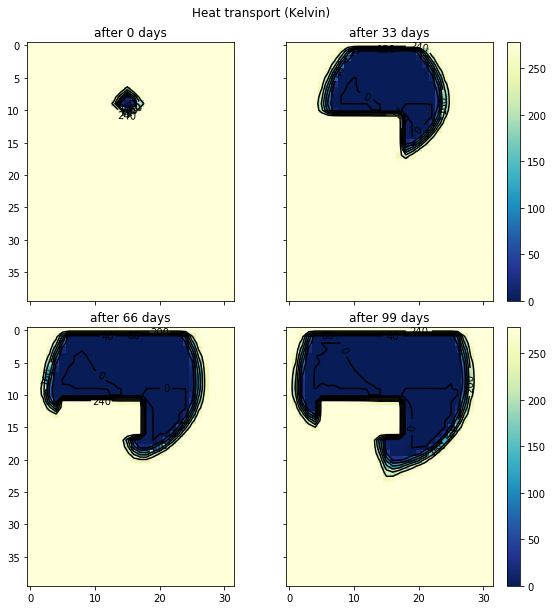

In [25]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    nrows=2, 
    ncols=2, 
    sharex=True, 
    sharey=True,
    figsize=(10,10), gridspec_kw={'hspace': 0.1, 'wspace': 0}
)
# axis 1 
im1 = ax1.imshow(conc[slice_no[0], 0, :, :], cmap='YlGnBu_r')
#plt.colorbar(im1, ax=ax1)

ct1 = ax1.contour(conc[slice_no[0], 0, :, :], zorder=10, colors='black')
plt.clabel(ct1, inline=1, fontsize=10, fmt='%d')
ax1.set_title(f'after {int(slice_no[0])} days')

# axis 2
im2 = ax2.imshow(conc[slice_no[1], 0, :, :], cmap='YlGnBu_r')
plt.colorbar(im2, ax=ax2)
ax2.set_title(f'after {int(slice_no[1])} days')

ct2 = ax2.contour(conc[slice_no[1], 0, :, :], zorder=10, colors='black')
plt.clabel(ct2, inline=1, fontsize=10, fmt='%d')

# axis 3
im3 = ax3.imshow(conc[slice_no[2], 0, :, :], cmap='YlGnBu_r')
#plt.colorbar(im3, ax=ax3)
ax3.set_title(f'after {int(slice_no[2])} days')

ct3 = ax3.contour(conc[slice_no[2], 0, :, :], zorder=10, colors='black')
plt.clabel(ct3, inline=1, fontsize=10, fmt='%d')

# axis 4
im4 = ax4.imshow(conc[slice_no[3], 0, :, :], cmap='YlGnBu_r')
plt.colorbar(im4, ax=ax4)
ax4.set_title(f'after {int(slice_no[3])} days')

ct4 = ax4.contour(conc[slice_no[3], 0, :, :], zorder=10, colors='black')
plt.clabel(ct4, inline=1, fontsize=10, fmt='%d')
f.suptitle('Heat transport (Kelvin)', y=0.93) 

plt.show()

In [26]:
conc[slice_no[3], 0, :, :].min()

-0.1939801